# Recurrent Neural Networks

In [42]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [43]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [44]:
from pandas.tseries.offsets import MonthEnd

In [45]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

C:\Users\Atiye\AppData\Local\Temp\ipykernel_17204\3942898399.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)


,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


<Axes: xlabel='Adjustments'>

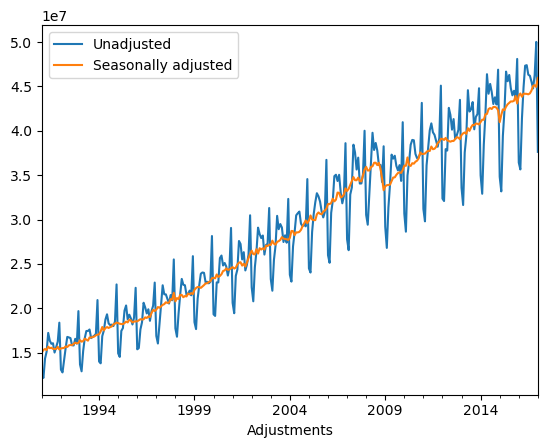

In [46]:
df.plot()

In [47]:
split_date = pd.Timestamp('01-01-2011')

In [48]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

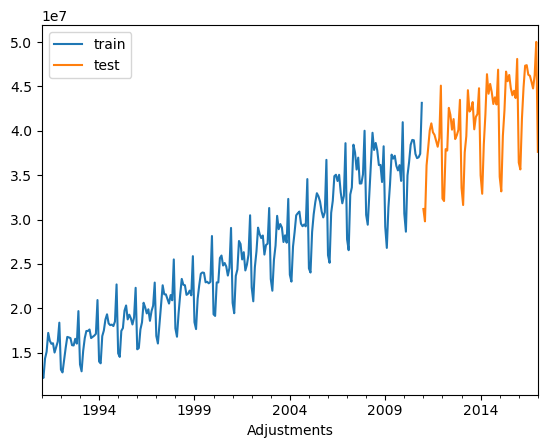

In [49]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [50]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [51]:
train_sc[:4]

array([[0.01402033],
       [0.        ],
       [0.0704258 ],
       [0.09531795]])

In [52]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

### Fully connected predictor

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

D:\Eyvazlou\anaconda3\envs\myML\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12)                  │              24 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

In [55]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [56]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0707
Epoch 2/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 0.0166
Epoch 3/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0138
Epoch 4/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 0.0137
Epoch 5/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098
Epoch 6/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0104
Epoch 7/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088
Epoch 8/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0084
Epoch 9/200
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.0108
Epoch 9: early stopping


In [57]:
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


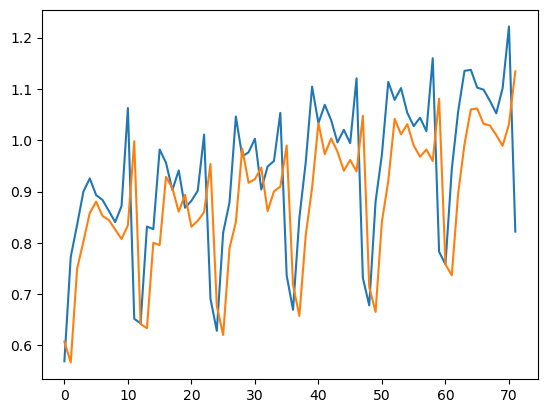

In [58]:
plt.plot(y_test)
plt.plot(y_pred)

### Recurrent predictor

In [59]:
from tensorflow.keras.layers import LSTM

In [60]:
X_train.shape

(239, 1)

In [61]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

(239, 1, 1)

In [62]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [63]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

D:\Eyvazlou\anaconda3\envs\myML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

Epoch 1/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.2095
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 0.0604
Epoch 2: early stopping


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


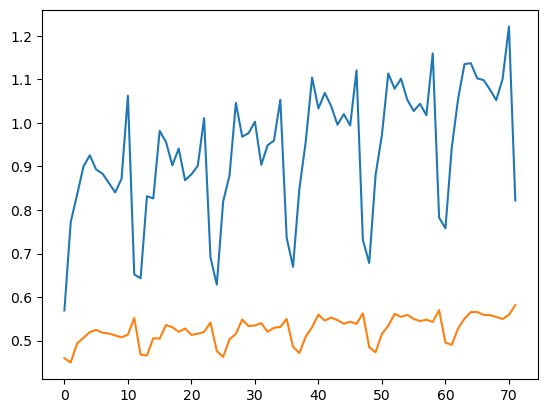

In [65]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Windows

In [66]:
train_sc.shape

(240, 1)

In [67]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Adjustments,
1991-01-31,0.014020
1991-02-28,0.000000
1991-03-31,0.070426
1991-04-30,0.095318
1991-05-31,0.163628


In [68]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [69]:
train_sc_df.head(13)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,,
1991-01-31,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-02-28,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-03-31,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-04-30,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-05-31,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-06-30,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-07-31,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN,NaN
1991-08-31,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN,NaN
1991-09-30,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020,NaN,NaN,NaN,NaN


In [70]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [71]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,shift_12
Adjustments,,,,,,,,,,,,
1992-01-31,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000,0.014020
1992-02-29,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426,0.000000
1992-03-31,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318,0.070426
1992-04-30,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628,0.095318
1992-05-31,0.109831,0.065964,0.019993,0.030027,0.200913,0.131738,0.111395,0.092309,0.126174,0.123958,0.135141,0.163628


In [72]:
X_train.shape

(228, 12)

In [73]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### Fully Connected on Windows

In [74]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

D:\Eyvazlou\anaconda3\envs\myML\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12)                  │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              13 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169 (676.00 B)

 Trainable params: 169 (676.00 B)

 Non-trainable params: 0 (0.00 B)

In [75]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/200
228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step - loss: 0.3755
Epoch 2/200
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 0.0254
Epoch 2: early stopping


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


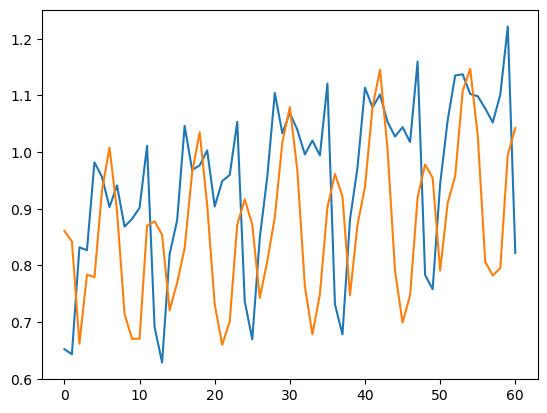

In [76]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

### LSTM on Windows

In [77]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [78]:
X_train_t.shape

(228, 1, 12)

In [79]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

D:\Eyvazlou\anaconda3\envs\myML\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [80]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 6)                   │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 463 (1.81 KB)

 Trainable params: 463 (1.81 KB)

 Non-trainable params: 0 (0.00 B)

In [81]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.3120
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0148
Epoch 2: early stopping


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


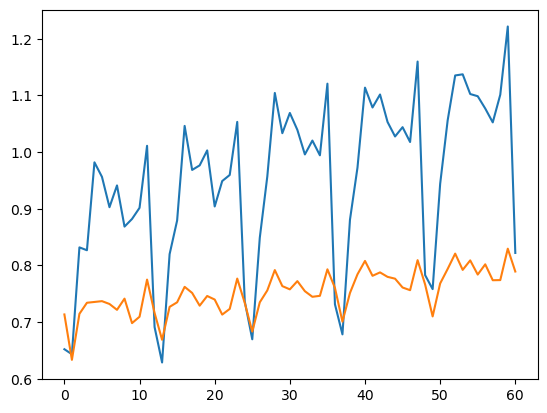

In [82]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)